In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models, transforms
import numpy as np

In [3]:
# --- Environment ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

# --- Preprocessing ---
transform = transforms.Compose([
    transforms.Resize((64, 64), interpolation=transforms.InterpolationMode.BILINEAR),  # Lightweight resizing
    transforms.ToTensor(),
])

def generate_random_images(num_samples=200, channels=3, height=64, width=64):
    X = torch.randn(num_samples, channels, height, width)  # Random images
    y = torch.randn(num_samples)  # Continuous targets for regression
    return X, y

X, y = generate_random_images()
train_size = int(0.8 * len(X))
train_dataset = TensorDataset(X[:train_size], y[:train_size])
test_dataset = TensorDataset(X[train_size:], y[train_size:])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# --- Load Pre-trained Model ---
base_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device)

# --- Freeze Backbone ---
for param in base_model.parameters():
    param.requires_grad = False

# --- Add New Classifier (Linear Regression Head) ---
class FeatureExtractorWithRegressor(nn.Module):
    def __init__(self, backbone):
        super(FeatureExtractorWithRegressor, self).__init__()
        self.backbone = nn.Sequential(*list(backbone.children())[:-1])  # Remove FC layer
        self.regressor = nn.Linear(backbone.fc.in_features, 1)  # Regression output

    def forward(self, x):
        features = self.backbone(x)  # Extract features
        features = features.view(features.size(0), -1)  # Flatten
        return self.regressor(features)  # Predict continuous value

model = FeatureExtractorWithRegressor(base_model).to(device)

In [4]:
# --- Train Classifier ---
criterion = nn.MSELoss()
optimizer = optim.Adam(model.regressor.parameters(), lr=0.001)  # Train only regressor

def train_model(model, loader, optimizer, criterion, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device).unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(loader):.4f}")

train_model(model, train_loader, optimizer, criterion)

# --- Evaluate ---
def evaluate_model(model, loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device).unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    print(f"Test MSE: {total_loss / len(loader):.4f}")

evaluate_model(model, test_loader)

Epoch 1/5, Loss: 1.2696
Epoch 2/5, Loss: 1.1655
Epoch 3/5, Loss: 0.9698
Epoch 4/5, Loss: 0.8721
Epoch 5/5, Loss: 0.8398
Test MSE: 1.0064


In [5]:
import matplotlib.pyplot as plt

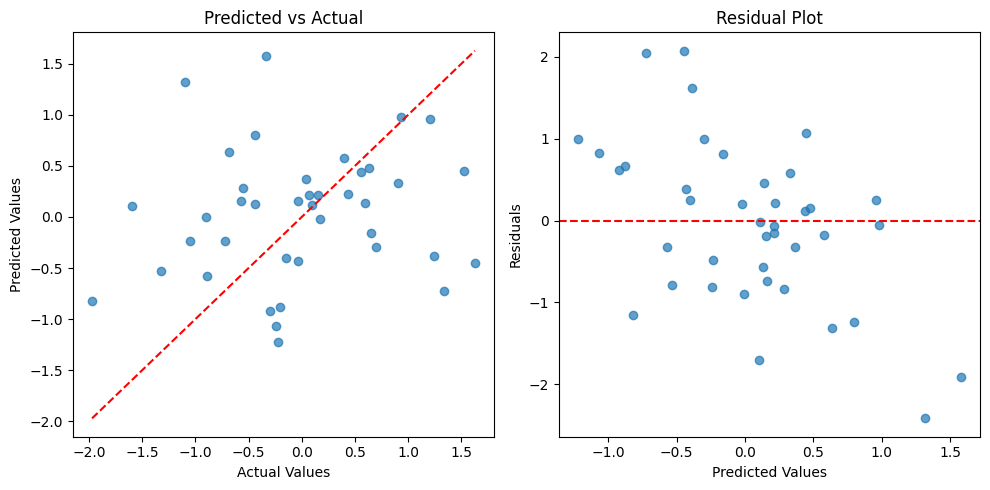

In [6]:
# --- Visualize Model Performance ---
def visualize_performance(model, loader):
    model.eval()
    actuals, predictions = [], []
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).squeeze(1)
            actuals.extend(targets.cpu().numpy())
            predictions.extend(outputs.cpu().numpy())

    # Predicted vs Actual Plot
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(actuals, predictions, alpha=0.7)
    plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Predicted vs Actual')

    # Residual Plot
    residuals = np.array(actuals) - np.array(predictions)
    plt.subplot(1, 2, 2)
    plt.scatter(predictions, residuals, alpha=0.7)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')

    plt.tight_layout()
    plt.show()

# Call the visualization function
visualize_performance(model, test_loader)